In [1]:
import re
import pathlib as pl
import tomllib
import colorsys
import matplotlib
import dataclasses
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from functools import cached_property, partial
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import Affine2D
from tqdm.contrib.concurrent import process_map
from tqdm.notebook import tqdm

from common.project import UnzippedProject
from scatterplots import hr, load_tsv_file, load_txt, EpochInfo, plot_netsize_from_epochs
from swarmsim.yaml import safe_load

from seaborn.categorical import _CategoricalPlotter  # pyright: ignore[reportAttributeAccessIssue]
from seaborn.utils import _scatter_legend_artist, _default_color  # pyright: ignore[reportAttributeAccessIssue]

In [2]:
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.labelsize'] = 12
# matplotlib.rcParams['legend.fontsize'] = 10
# matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['savefig.dpi'] = 300

sideways_dia = MarkerStyle('d', None, Affine2D().rotate_deg(90))

%matplotlib widget

In [3]:
class Run(UnzippedProject):
    @cached_property
    def fitness_df(self):
        data = load_tsv_file(self.popfit_path)
        df = pd.DataFrame(data).T
        df.index = ('time', 'epoch', 'fitnesses')
        df = df.T
        df['time'] = df['time'].astype(float)
        df['epoch'] = df['epoch'].astype(int)
        df['fitnesses'] = df['fitnesses'].apply(eval)
        return df

In [4]:
folder = pl.Path('~/250108').expanduser()

projects = [Run(p) for p in folder.iterdir() if p.is_dir()]

In [5]:
fitnesses_per_run = [max(p.fitness_df['fitnesses'], default=0) for p in projects]
fitnesses_per_epoch = list(zip(*fitnesses_per_run))
# epoch_idxs = range(len(fitnesses_per_run[0]))

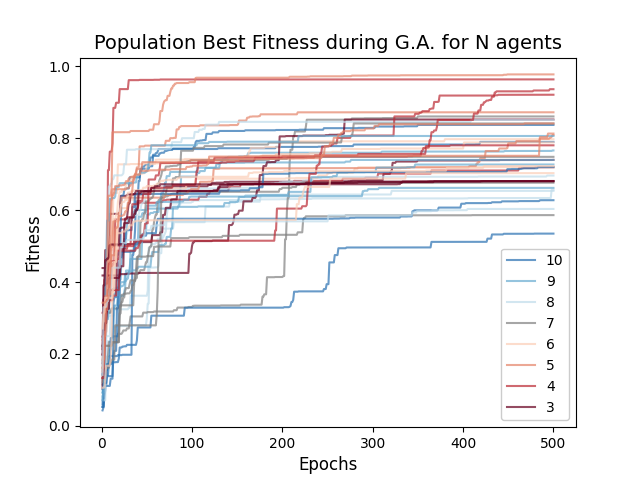

In [6]:
fig, ax = plt.subplots(1, 1)
ax: plt.Axes

for p in projects:
    best_fitness_per_epoch = p.fitness_df['fitnesses'].apply(max)
    n_robots = p.env['spawners'][0]['n']
    color = cm.RdBu((n_robots - 3)/8) if n_robots != 7 else 'gray'
    ax.plot(p.fitness_df['epoch'], best_fitness_per_epoch, alpha=0.7, c=color, label=n_robots)

plt.xlabel("Epochs")
plt.ylabel("Fitness")
plt.title("Population Best Fitness during G.A. for N agents")
# make legend of unique labels, sorted by label
d = {int(label): handle for handle, label in zip(*ax.get_legend_handles_labels())}
labels = sorted(d.keys())[::-1]
handles = [d[label] for label in labels]
ax.legend(handles, labels, loc='lower right', framealpha=1.0)
%matplotlib widget
# plt.savefig('popfit_n.pdf')


In [7]:
folder = pl.Path('~/neuromorphic/results/sp25').expanduser()


def extract_tenn2_maxs(project):
    with Run(project) as p:
        _t, _e, fitnesses, *_ = p.read_popfit()
        arr = np.array([li for li in fitnesses if li])
        # epoch_idxs = np.indices(arr.shape)[0]
        max_fitness = np.max(arr)
        n_robots = p.env['spawners'][0]['n']
        # print(f"{p.name}\t{behavior.name}\tN: {n_robots}\tmax: {max_fitness}")
        behavior = p.env['metrics'][0]['name']
        behavior = behavior.replace('Delaunay Dispersal', 'Delaunay Diffusion')
        return {
            'behavior': behavior,
            'n_robots': n_robots,
            'max_fitness': max_fitness,
        }


files = [pzip for behavior in folder.iterdir()
         for pzip in list(behavior.iterdir())]

test = extract_tenn2_maxs(next(iter(files)))
test

{'behavior': 'InteragentDispersion',
 'n_robots': 7,
 'max_fitness': np.float64(7.862073704039821)}

In [8]:
finalfits = process_map(extract_tenn2_maxs, files)

df1 = pd.DataFrame(finalfits)
df1

  0%|          | 0/418 [00:00<?, ?it/s]

,behavior,n_robots,max_fitness
0,InteragentDispersion,7,7.862074
1,InteragentDispersion,8,8.007349
2,InteragentDispersion,5,8.550547
3,InteragentDispersion,4,8.890730
4,InteragentDispersion,9,7.866218
...,...,...,...
413,Delaunay Diffusion,8,19.946381
414,Delaunay Diffusion,10,6.782931
415,Delaunay Diffusion,10,9.123730
416,Delaunay Diffusion,7,25.069068


In [9]:
def plot_strips(
    self,
    jitter,
    dodge,
    color,
    plot_kws,
):

    width = .8 * self._native_width
    offsets = self._nested_offsets(width, dodge)

    if jitter is True:
        jlim = 0.1
    else:
        jlim = float(jitter)
    if "hue" in self.variables and dodge and self._hue_map.levels is not None:
        jlim /= len(self._hue_map.levels)
    jlim *= self._native_width
    jitterer = partial(np.random.uniform, low=-jlim, high=+jlim)

    iter_vars = [self.orient]
    if dodge:
        iter_vars.append("hue")

    ax = self.ax
    dodge_move = jitter_move = 0

    if "marker" in plot_kws and not MarkerStyle(plot_kws["marker"]).is_filled():
        plot_kws.pop("edgecolor", None)

    using_facets = 'row' in iter_vars or 'col' in iter_vars or self.ax is None
    # add twinx axes for each hue level
    if not using_facets:
        axs = [self.ax]
        for _ in range(1, len(self._hue_map.levels)):
            axs.append(self.ax.twinx())

    for sub_vars, sub_data in self.iter_data(iter_vars,
                                                from_comp_data=True,
                                                allow_empty=True):

        if using_facets:
            ax = self._get_axes(sub_vars)
        else:
            assert sub_data["hue"].nunique() == 1
            cat = sub_data["hue"].iloc[0]
            idx = self._hue_map.levels.index(cat)
            ax = axs[idx]
            if idx > 1:
                offset = 1 + (idx - 1) * 0.2
                ax.spines.right.set_position(('axes', offset))
        ax: plt.Axes

        if offsets is not None and (offsets != 0).any():
            dodge_move = offsets[sub_data["hue"].map(self._hue_map.levels.index)]

        jitter_move = jitterer(size=len(sub_data)) if len(sub_data) > 1 else 0

        adjusted_data = sub_data[self.orient] + dodge_move + jitter_move
        sub_data[self.orient] = adjusted_data
        self._invert_scale(ax, sub_data)

        points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
        if "hue" in self.variables:
            points.set_facecolors(self._hue_map(sub_data["hue"]))
        if not using_facets:
            colors = points.get_facecolors()
            avg_color = np.mean(colors, axis=0)
            if len(avg_color) > 3:
                avg_color[3] = 1.0
            ax.tick_params(axis='y', colors=avg_color)
            ax_oriented = ax.yaxis if self.orient == 'x' else ax.xaxis
            ax_oriented.label.set(text=cat, color=avg_color)

    self._configure_legend(ax, _scatter_legend_artist, common_kws=plot_kws)


_CategoricalPlotter.plot_strips = plot_strips

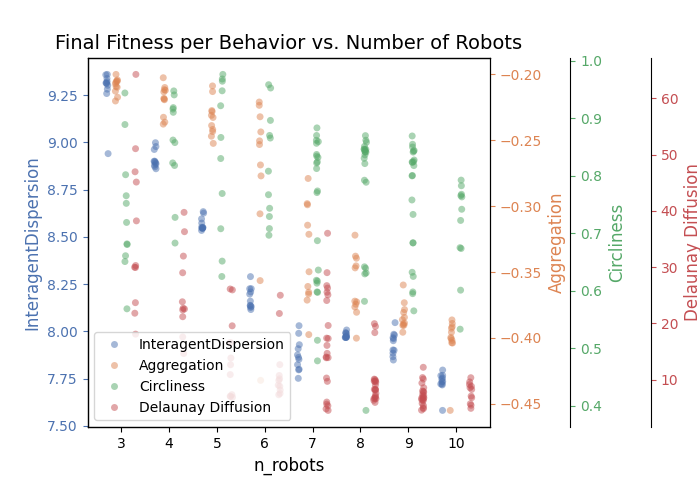

In [10]:
sns.set_palette('deep')
fig = plt.figure()
sns.stripplot(data=df1, x='n_robots', y='max_fitness', hue='behavior',
              jitter=True, dodge=True, alpha=0.5, zorder=1, native_scale=True)
fig.subplots_adjust(right=0.7)
fig.set_figwidth(7)
fig.axes[-1].legend(loc='lower left')

# sns.pointplot(data=df, x='n_robots', y='max_fitness', hue='behavior',
#               dodge=.8 - .8 / 4, palette='dark', markers=sideways_dia, markersize=4, linestyle='none', errorbar=('pi', 100))
plt.title('Final Fitness per Behavior vs. Number of Robots')
plt.savefig('behavior_fitness.pdf')

In [11]:
# project = next(iter(files))
def extract_tenn2_popfits(project):
    with Run(project) as p:
        _t, _e, fitnesses, *_ = p.read_popfit()
        arr = np.array([li for li in fitnesses if li])
        # epoch_idxs = np.indices(arr.shape)[0]
        n_robots = p.env['spawners'][0]['n']
        # print(f"{p.name}\t{behavior.name}\tN: {n_robots}\tmax: {max_fitness}")
        behavior = p.env['metrics'][0]['name']
        behavior = behavior.replace('Delaunay Dispersal', 'Delaunay Diffusion')
        return [
            {
                'behavior': behavior,
                'n_robots': n_robots,
                'max_fitness': np.max(fits),
                'epoch': epoch,
            }
            for epoch, fits in enumerate(arr)
        ]


allfits = process_map(extract_tenn2_popfits, files)

df2 = pd.DataFrame(sum(allfits, []))
df2

  0%|          | 0/418 [00:00<?, ?it/s]

,behavior,n_robots,max_fitness,epoch
0,InteragentDispersion,7,6.973784,0
1,InteragentDispersion,7,7.073532,1
2,InteragentDispersion,7,7.074683,2
3,InteragentDispersion,7,7.074683,3
4,InteragentDispersion,7,7.074683,4
...,...,...,...,...
208995,Delaunay Diffusion,6,8.857524,495
208996,Delaunay Diffusion,6,8.857524,496
208997,Delaunay Diffusion,6,8.857524,497
208998,Delaunay Diffusion,6,9.018994,498


In [12]:
behaviors = df2['behavior'].unique()


def plot_behavior(behavior, sort=True):
    fig = plt.figure()
    fig.set_size_inches(7, 5)
    artists = sns.lineplot(data=df2[df2['behavior'] == behavior],
                           x='epoch', y='max_fitness', hue='n_robots',
                           errorbar=('pi', 100), palette='viridis', legend='full')
    ax = plt.gca()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Best Population Fitness')
    ax.set_title(f'{behavior}')
    return fig, ax, artists


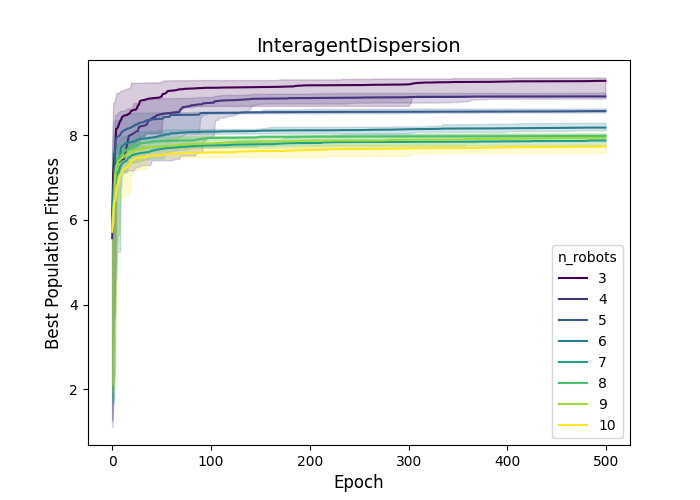

In [13]:
fig, ax, artists = plot_behavior(behaviors[0])
plt.show()
plt.savefig(f'epochs_{behaviors[0]}.pdf')

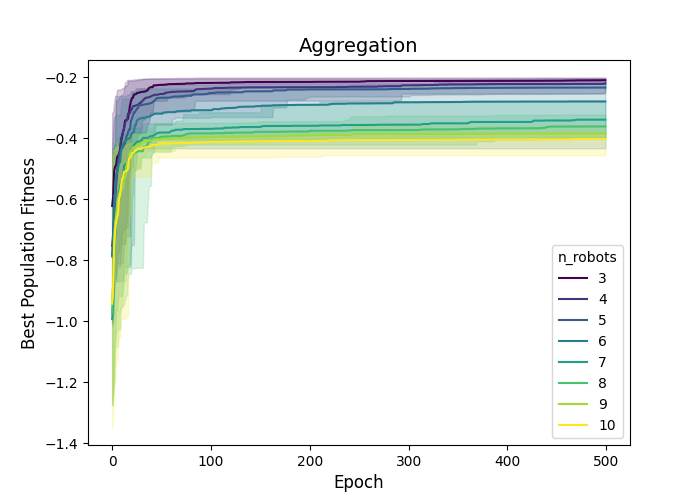

In [14]:
plot_behavior(behaviors[1])
plt.show()
plt.savefig(f'epochs_{behaviors[1]}.pdf')

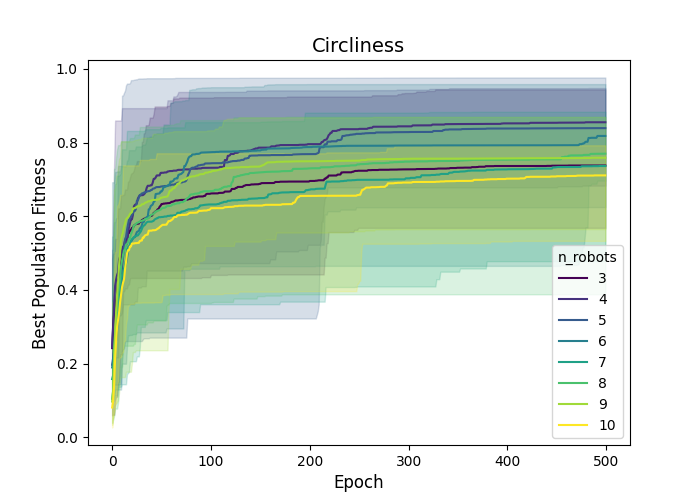

In [15]:
plot_behavior(behaviors[2])
plt.show()
plt.savefig(f'epochs_{behaviors[2]}.pdf')

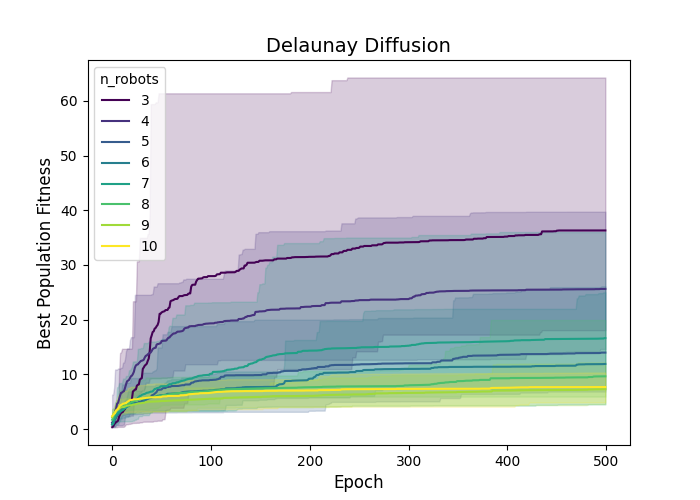

In [16]:
plot_behavior(behaviors[3])
plt.show()
plt.savefig(f'epochs_{behaviors[3]}.pdf')

In [17]:
def ei_dict(epochinfo: EpochInfo):
    d = dataclasses.asdict(epochinfo)
    d.update({
        "t_total": epochinfo.t_total,
        "num_neurons": epochinfo.num_neurons,
        "num_synapses": epochinfo.num_synapses,
    })
    return d

In [18]:
def extract_tenn2_data(project):
    with Run(project) as p:
        _t, _e, fitnesses, *_ = p.read_popfit()
        arr = np.array([li for li in fitnesses if li])
        bests = arr.max(axis=1)
        # epoch_idxs = np.indices(arr.shape)[0]
        n_robots = p.env['spawners'][0]['n']
        # print(f"{p.name}\t{behavior.name}\tN: {n_robots}\tmax: {max_fitness}")
        behavior = p.env['metrics'][0]['name']
        behavior = behavior.replace('Delaunay Dispersal', 'Delaunay Diffusion')

        lines = p.logfile.read_lines()
        epochinfos = [x for line in lines for x in [EpochInfo.from_str(line, error=False)] if x]

        return {
            'n_robots': n_robots,
            'eons_seed': p.evolver['app']['eons_seed'],
            'fitnesses': pd.Series(bests),
            'netsize': pd.DataFrame([ei_dict(ei) for ei in epochinfos]),
            # 'proj': p.name
        }


behavior_dirs = {subdir.name: [pzip for pzip in subdir.iterdir()]
         for subdir in list(folder.iterdir())}

behavior_data = {behavior: process_map(extract_tenn2_data, files)
                 for behavior, files in behavior_dirs.items()}

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

In [19]:
from seaborn.relational import _LinePlotter


def setup_lineplotter(
    data=None, *,
    x=None, y=None, hue=None, size=None, style=None, units=None, weights=None,
    palette=None, hue_order=None, hue_norm=None,
    sizes=None, size_order=None, size_norm=None,
    dashes=True, markers=None, style_order=None,
    estimator="mean", errorbar=("ci", 95), n_boot=1000, seed=None,
    orient="x", sort=True, err_style="band", err_kws=None,
    legend="auto", ax=None, **kwargs
):
    p = _LinePlotter(
        data=data,
        variables=dict(
            x=x, y=y, hue=hue, size=size, style=style, units=units, weight=weights
        ),
        estimator=estimator, n_boot=n_boot, seed=seed, errorbar=errorbar,
        sort=sort, orient=orient, err_style=err_style, err_kws=err_kws,
        legend=legend,
    )

    p.map_hue(palette=palette, order=hue_order, norm=hue_norm)
    p.map_size(sizes=sizes, order=size_order, norm=size_norm)
    p.map_style(markers=markers, dashes=dashes, order=style_order)

    if ax is None:
        ax = plt.gca()

    if "style" not in p.variables and not {"ls", "linestyle"} & set(kwargs):  # XXX
        kwargs["dashes"] = "" if dashes is None or isinstance(dashes, bool) else dashes

    # Other functions have color as an explicit param,
    # and we should probably do that here too
    color = kwargs.pop("color", kwargs.pop("c", None))
    kwargs["color"] = _default_color(ax.plot, hue, color, kwargs)

    p.kwargs = kwargs
    if not p.has_xy_data:
        p.ax = ax
        return p
    p._attach(ax)
    return p


def lineplot(self):
    import matplotlib as mpl
    from seaborn.utils import normalize_kwargs, _get_transform_functions, adjust_legend_subtitles
    from seaborn._compat import groupby_apply_include_groups
    from seaborn._statistics import EstimateAggregator, WeightedAggregator
    ax = self.ax
    kws = self.kwargs
    kws = normalize_kwargs(kws, mpl.lines.Line2D)
    kws.setdefault("markeredgewidth", 0.75)
    kws.setdefault("markeredgecolor", "w")

    self.fills = []
    self.lines = {}

    # Set default error kwargs
    err_kws = self.err_kws.copy()
    if self.err_style == "band":
        err_kws.setdefault("alpha", 0.2)
    elif self.err_style == "bars":
        pass
    elif self.err_style is not None:
        err = "`err_style` must be 'band' or 'bars', not {}"
        raise ValueError(err.format(self.err_style))

    est_kws = kws.copy()
    est_kws.setdefault('linewidth', 0.5)

    # Initialize the aggregation object
    weighted = "weight" in self.plot_data
    agg = (WeightedAggregator if weighted else EstimateAggregator)(
        self.estimator, self.errorbar, n_boot=self.n_boot, seed=self.seed,
    )

    # TODO abstract variable to aggregate over here-ish. Better name?
    orient = self.orient
    if orient not in {"x", "y"}:
        err = f"`orient` must be either 'x' or 'y', not {orient!r}."
        raise ValueError(err)
    other = {"x": "y", "y": "x"}[orient]

    # Loop over the semantic subsets and add to the plot
    grouping_vars = "hue", "size", "style"
    for sub_vars, sub_data in self.iter_data(grouping_vars, from_comp_data=True):

        if self.sort:
            sort_vars = ["units", orient, other]
            sort_cols = [var for var in sort_vars if var in self.variables]
            sub_data = sub_data.sort_values(sort_cols)

        if (
            self.estimator is not None
            and sub_data[orient].value_counts().max() > 1
        ):
            if "units" in self.variables:
                # TODO eventually relax this constraint
                err = "estimator must be None when specifying units"
                raise ValueError(err)
            grouped = sub_data.groupby(orient, sort=self.sort)
            # Could pass as_index=False instead of reset_index,
            # but that fails on a corner case with older pandas.
            sub_data = (
                grouped
                .apply(agg, other, **groupby_apply_include_groups(False))
                .reset_index()
            )
        else:
            sub_data[f"{other}min"] = np.nan
            sub_data[f"{other}max"] = np.nan

        # Apply inverse axis scaling
        for var in "xy":
            _, inv = _get_transform_functions(ax, var)
            for col in sub_data.filter(regex=f"^{var}"):
                sub_data[col] = inv(sub_data[col])

        # --- Draw the main line(s)

        if "units" in self.variables:   # XXX why not add to grouping variables?
            lines = []
            for _, unit_data in sub_data.groupby("units"):
                lines.extend(ax.plot(unit_data["x"], unit_data["y"], **kws))
        else:
            lines = []
            # lines = ax.plot(sub_data["x"], sub_data["y"], **kws)
            lines.extend(ax.plot(sub_data["x"], sub_data[f"{other}min"], **est_kws))
            lines.extend(ax.plot(sub_data["x"], sub_data[f"{other}max"], **est_kws))

        for line in lines:

            if "hue" in sub_vars:
                line.set_color(self._hue_map(sub_vars["hue"]))
                # pass

            if "size" in sub_vars:
                line.set_linewidth(self._size_map(sub_vars["size"]))

            if "style" in sub_vars:
                attributes = self._style_map(sub_vars["style"])
                if "dashes" in attributes:
                    line.set_dashes(attributes["dashes"])
                if "marker" in attributes:
                    line.set_marker(attributes["marker"])

        line_color = line.get_color()
        line_alpha = line.get_alpha()
        line_capstyle = line.get_solid_capstyle()

        # --- Draw the confidence intervals

        if self.estimator is not None and self.errorbar is not None:

            # TODO handling of orientation will need to happen here

            if self.err_style == "band":

                func = {"x": ax.fill_between, "y": ax.fill_betweenx}[orient]
                self.fills.append(func(
                    sub_data[orient],
                    sub_data[f"{other}min"], sub_data[f"{other}max"],
                    color=line_color,
                    # facecolor='#1234560f',
                    **err_kws
                ))

            elif self.err_style == "bars":
                raise NotImplementedError

    # Finalize the axes details
    self._add_axis_labels(ax)
    if self.legend:
        legend_artist = partial(mpl.lines.Line2D, xdata=[], ydata=[])
        attrs = {"hue": "color", "size": "linewidth", "style": None}
        self.add_legend_data(ax, legend_artist, kws, attrs)
        handles, _ = ax.get_legend_handles_labels()
        if handles:
            legend = ax.legend(title=self.legend_title)
            adjust_legend_subtitles(legend)

In [20]:
def find_best(df):
    temp_df = df.reset_index()
    return (temp_df.iloc[temp_df.idxmax()['max_fitness']]
            [['eons_seed', 'n_robots']].to_dict())


def find_df_by(behavior_data, n_robots, eons_seed):
    for d in behavior_data:
        if d['n_robots'] == n_robots and d['eons_seed'] == eons_seed:
            return d


# build df of fitnesses per eons_seed
lfdfs = {}
for behavior, data in behavior_data.items():
    lfdf = pd.DataFrame()
    for d in data:
        if any(lfdf) and (any((lfdf['eons_seed'] == d['eons_seed']) & (lfdf['n_robots'] == d['n_robots']))):
            continue  # skip duplicate
        df = pd.DataFrame(d['fitnesses'], columns=['max_fitness'])
        df.index.name = 'epoch'
        df['eons_seed'] = d['eons_seed']
        df['n_robots'] = d['n_robots']
        lfdf = pd.concat([lfdf, df], axis=0)
    lfdfs[behavior] = lfdf

In [21]:
def plot_best_shadow(df, fig=None):
    if fig is None:
        fig, ax = plt.subplots()
    else:
        ax = fig.gca()
    p = setup_lineplotter(data=df,
                        x='epoch', y='max_fitness', hue='n_robots', style='n_robots',
                        errorbar=('pi', 100), legend='full', palette='viridis',
                        ax=ax
                        )
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Best Population Fitness')
    # ax.fill_between(df.index, df['max_fitness'], df['max_fitness'])
    # ax.set_title(f'{behavior}')
    lineplot(p)
    for n_robots in sorted(df['n_robots'].unique()):
        sub_data = df[df['n_robots'] == n_robots]
        best_seed = sub_data.groupby('eons_seed').max().idxmax()['max_fitness']
        best_data = sub_data[sub_data['eons_seed'] == best_seed]
        lines = ax.plot(best_data.index, best_data['max_fitness'])
        for line in lines:
            if "hue" in p.variables:
                line.set_color(p._hue_map(n_robots))
            if "size" in p.variables:
                line.set_linewidth(p._size_map(n_robots))
            if "style" in p.variables:
                attributes = p._style_map(n_robots)
                if "dashes" in attributes:
                    line.set_dashes(attributes["dashes"])
                if "marker" in attributes:
                    line.set_marker(attributes["marker"])
    return fig, ax, p

In [22]:
def plot_shadow_netsize(behavior, title=None):
    fig = plt.figure(layout="constrained")
    fig.set_size_inches(7, 6)
    figs = fig.subfigures(2, 1, height_ratios=[1, 0.5], hspace=0.02)
    _fig, ax, p = plot_best_shadow(lfdfs[behavior], fig=figs[0])
    plt.gca().set_title(behavior if title is None else title)
    plot_netsize_from_epochs(figs[1], figs[1].subplots(),
                            find_df_by(behavior_data[behavior], **find_best(lfdfs[behavior]))['netsize'])
    plt.savefig(f'epochs_combi_{behavior}.pdf')
    return fig, p

In [23]:
find_df_by(behavior_data['aggregation'], **find_best(lfdfs['aggregation']))['netsize']

,i,t_start,t_fitness,t_eons,t_end,t_elapsed,best_net_id,best_network,best_fitness,best_score,validation,fitnesses,t_total,num_neurons,num_synapses
0,1,1.753814e+09,3.2744,0.0019,1.753814e+09,3.2766,None,None,-0.9704,-0.9704,None,(),3.2766,16,20
1,2,1.753814e+09,3.1566,0.0015,1.753814e+09,3.1583,None,None,-0.9704,-0.9704,None,(),3.1583,16,19
2,3,1.753814e+09,3.1992,0.0016,1.753814e+09,3.2010,None,None,-0.8582,-0.8582,None,(),3.2010,18,14
3,4,1.753814e+09,3.2098,0.0012,1.753814e+09,3.2112,None,None,-0.8582,-0.8582,None,(),3.2112,16,15
4,5,1.753814e+09,3.2845,0.0024,1.753814e+09,3.2870,None,None,-0.8582,-0.8582,None,(),3.2870,16,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,1.753816e+09,3.0030,0.0022,1.753816e+09,3.0053,None,None,-0.2002,-0.2002,None,(),3.0053,6,8
496,497,1.753816e+09,3.1951,0.0019,1.753816e+09,3.1972,None,None,-0.2002,-0.2002,None,(),3.1972,6,8
497,498,1.753816e+09,3.0147,0.0021,1.753816e+09,3.0170,None,None,-0.2002,-0.2002,None,(),3.0170,6,8
498,499,1.753816e+09,2.9458,0.0020,1.753816e+09,2.9480,None,None,-0.2002,-0.2002,None,(),2.9480,6,8


In [24]:
find_best(lfdfs['aggregation'])


{'eons_seed': 25.0, 'n_robots': 3.0}

In [25]:
p = Run(r'/home/videblu/neuromorphic/results/sp25/aggregation/250729-143414-rss_snn_eons_agg-es25_n3.zip')
p.unzip()
lines = p.logfile.read_lines()
[x for line in lines for x in [EpochInfo.from_str(line, error=False)] if x]

[EpochInfo(i=1, t_start=1753814054.7234, t_fitness=3.2744, t_eons=0.0019, t_end=1753814058.0, t_elapsed=3.2766, best_net_id=None, best_network=None, best_fitness=-0.9704, best_score=-0.9704, validation=None, fitnesses=()),
 EpochInfo(i=2, t_start=1753814057.8417, t_fitness=3.1566, t_eons=0.0015, t_end=1753814061.0, t_elapsed=3.1583, best_net_id=None, best_network=None, best_fitness=-0.9704, best_score=-0.9704, validation=None, fitnesses=()),
 EpochInfo(i=3, t_start=1753814060.799, t_fitness=3.1992, t_eons=0.0016, t_end=1753814064.0, t_elapsed=3.201, best_net_id=None, best_network=None, best_fitness=-0.8582, best_score=-0.8582, validation=None, fitnesses=()),
 EpochInfo(i=4, t_start=1753814063.7888, t_fitness=3.2098, t_eons=0.0012, t_end=1753814067.0, t_elapsed=3.2112, best_net_id=None, best_network=None, best_fitness=-0.8582, best_score=-0.8582, validation=None, fitnesses=()),
 EpochInfo(i=5, t_start=1753814067.713, t_fitness=3.2845, t_eons=0.0024, t_end=1753814071.0, t_elapsed=3.287, 

In [26]:
EpochInfo.from_str(lines[3])

EpochInfo(i=1, t_start=1753814054.7234, t_fitness=3.2744, t_eons=0.0019, t_end=1753814058.0, t_elapsed=3.2766, best_net_id=None, best_network=None, best_fitness=-0.9704, best_score=-0.9704, validation=None, fitnesses=())

/mnt/c/Users/kenbl/OneDrive/Documents/.projects/blimplab/neuromorphic/turtwig/scatterplots.py:209: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.24)
/mnt/c/Users/kenbl/OneDrive/Documents/.projects/blimplab/neuromorphic/turtwig/scatterplots.py:211: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0.11, right=0.95)


(<Figure size 700x600 with 2 Axes>,
 <seaborn.relational._LinePlotter at 0x7f8096cd0c30>)

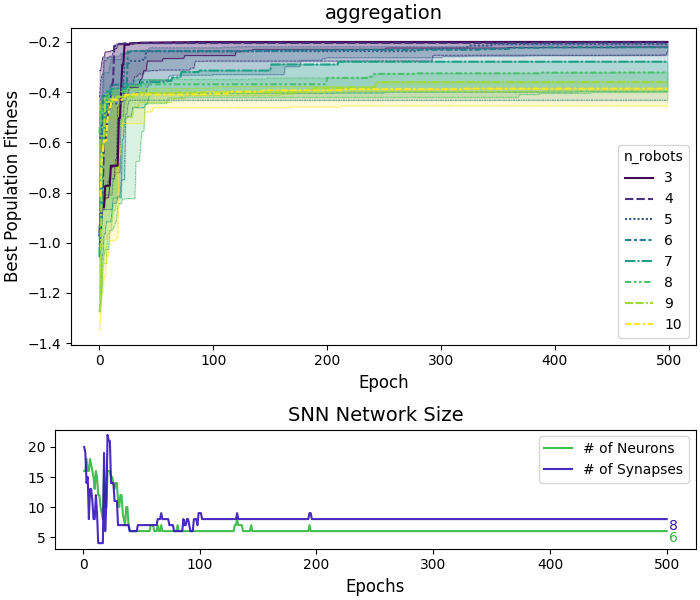

In [27]:
plot_shadow_netsize('aggregation')